In [1]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
from snntorch import utils
from snntorch import spikegen

MNIST Data

In [2]:
# dataloader arguments
batch_size = 128
data_path='/data/mnist'
num_steps=100
n_in=28

dtype = torch.float
#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = 'cpu'

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

#subset = 10
#mnist_train = utils.data_subset(mnist_train, subset)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

print(len(train_loader), len(test_loader))


468 78


DVS data

In [85]:
from src.io.psee_loader import PSEELoader

import pathlib
from glob import glob

delta_t = 10000
n = 75
skip = 100

vids = map(PSEELoader, glob("Prophesee_Dataset_n_cars/n-cars_train/cars/*_td.dat"))
# height, width = vid.get_size()
height, width = 120, 120
# vid.seek_time(skip)
event_seqs = [next(vids).load_delta_t(delta_t) for _ in range(n)]
# N = len(event_seqs)

#print(event_seqs[0])

dat = np.zeros((n, delta_t, 30, 30),dtype=np.int8)
for i,block in enumerate(event_seqs):
    for ev in block:
        dat[i,ev[0],ev[1]//4,ev[2]//4] = ev[3]
# for ev in events:
#     dat[ev[0],ev[1],ev[2]] = ev[3]

# dat = decimate(dat,4,axis=2)
# dat = decimate(dat,4,axis=3)

train_data = dat[0:60,:,:,:]
test_data  = dat[60:75,:,:,:]

train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], -1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], -1))

print(train_data.shape, test_data.shape)

(60, 10000, 900) (15, 10000, 900)


In [76]:
batch_size = 8
data_path='/data/mnist'
num_steps=100
n_in = 30

class RegressionDataset(Dataset):
    def __init__(self, x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

train_loader = DataLoader(RegressionDataset(train_data, train_data), batch_size=batch_size)
test_loader  = DataLoader(RegressionDataset(test_data, test_data),  batch_size=batch_size)


In [3]:
# Network Architecture
num_inputs = n_in*n_in
num_hidden = 1000
num_outputs = n_in*n_in

# Temporal Dynamics
num_steps = 25
beta = 0.95

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        #print(torch.stack(spk2_rec, dim=0))

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

In [4]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    targets = targets.view(batch_size,-1).numpy()
    #_, idx = output.sum(dim=0).max(1)
    #_, idx = output.sum(dim=0).max(1)
    #acc = np.mean((targets == idx).detach().cpu().numpy())
    #print('op',output.shape, targets.shape)
    avg_rate_output = output.mean(axis=0).detach().numpy()
    acc = np.mean((avg_rate_output - targets)**2)

    #acc = np.mean((targets - idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc}")
    else:
        print(f"Test set accuracy for a single minibatch: {acc}")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [6]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [6]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = data.view(batch_size, -1).to(device)

print(data.shape, targets.shape)

print(targets.shape, data.view(batch_size, -1).shape)

spk_rec, mem_rec = net(data.view(batch_size, -1))
print(spk_rec.size(), mem_rec.size())

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

torch.Size([128, 1, 28, 28]) torch.Size([128, 784])
torch.Size([128, 784]) torch.Size([128, 784])
torch.Size([25, 784]) torch.Size([25, 784])


/home/karthik/miniconda3/envs/neuromorphic/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([128, 784])) that is different to the input size (torch.Size([784])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [8]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
#loss_val.backward()

# weight update
#optimizer.step()

In [9]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = data.to(device)#targets.to(device)
        targets = targets.squeeze(1)

        # Spiking Data
        spike_data = spikegen.rate(data, num_steps=num_steps)
        #print(spike_data.shape)

        #print(targets.shape)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(spike_data.view(num_steps,batch_size, -1))

        #print(spk_rec.shape, mem_rec.shape, data.shape, targets.shape)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val = loss(spk_rec.mean(axis=0), targets.view(batch_size,-1))
        #for step in range(num_steps):
            #loss_val += loss(spk_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_data.to(device)#test_targets.to(device)

            spike_data_test = spikegen.rate(data, num_steps=num_steps)

            # Test set forward pass
            test_spk, test_mem = net(spike_data_test.view(num_steps, batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            test_loss = loss(test_spk.mean(axis=0), test_targets.view(batch_size,-1))
            #for step in range(num_steps):
                #test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 0.11
Test Set Loss: 0.11
Train set accuracy for a single minibatch: 0.10567966848611832
Test set accuracy for a single minibatch: 0.10735976696014404


Epoch 0, Iteration 50
Train Set Loss: 0.04
Test Set Loss: 0.11
Train set accuracy for a single minibatch: 0.0757414698600769
Test set accuracy for a single minibatch: 0.07291780412197113


Epoch 0, Iteration 100
Train Set Loss: 0.04
Test Set Loss: 0.11
Train set accuracy for a single minibatch: 0.08040967583656311
Test set accuracy for a single minibatch: 0.074870765209198


Epoch 0, Iteration 150
Train Set Loss: 0.04
Test Set Loss: 0.10
Train set accuracy for a single minibatch: 0.0772239938378334
Test set accuracy for a single minibatch: 0.07322615385055542


Epoch 0, Iteration 200
Train Set Loss: 0.04
Test Set Loss: 0.10
Train set accuracy for a single minibatch: 0.07320117205381393
Test set accuracy for a single minibatch: 0.07924243062734604


Epoch 0, Iteration 250
Train Set Loss: 0.04
Test Set

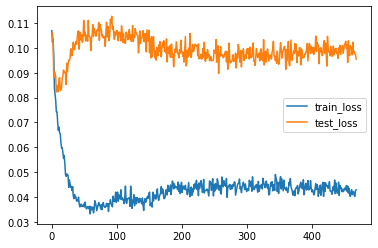

In [10]:
plt.figure()
plt.plot(loss_hist, label='train_loss')
plt.plot(test_loss_hist, label='test_loss')
plt.legend()

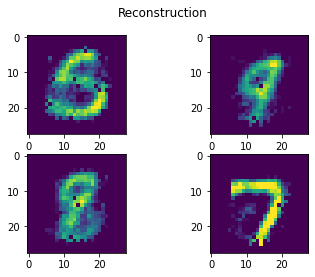

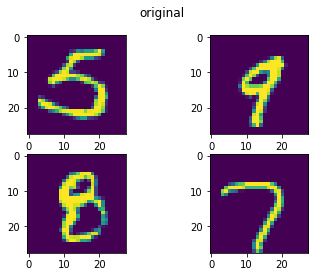

In [30]:
test_data, test_targets = next(iter(test_loader))

plt.figure()
for i in range(4):
    # Integrate through time for each location while displaying final image
    dat = test_data[i,:]
    dat = spikegen.rate(dat, num_steps=num_steps)
    spk_rec, mem_rec = net(dat.view(num_steps, 1, -1))
    final_image = spike_int = spk_rec.sum(0)[0].detach().numpy()
    #plt.figure()
    plt.subplot(2,2,i+1)
    plt.imshow(final_image.reshape((28, 28)))
    plt.suptitle('Reconstruction')
plt.show()

plt.figure()
for i in range(4):
    # Integrate through time for each location while displaying final image
    final_image = test_data[i,:].numpy()
    #plt.figure()
    plt.subplot(2,2,i+1)
    plt.imshow(final_image.reshape((28, 28)))
    plt.suptitle('original')
plt.show()

    
